# Project 4

In this project, you will summarize and present your analysis from Projects 1-3.

In [53]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from sklearn import cross_validation, linear_model, metrics

In [2]:
admissions_data = pd.read_csv('assets/admissions.csv')

**Problem Statement:** Determine which factors are most relevant when applying to a graduate program.

The data originally comes from a [tutorial on Logit Regression in R](http://www.ats.ucla.edu/stat/r/dae/logit.htm) from UCLA. Admission is encoded in the `admit` column, as either a `1` (admission) or `0` (rejection.) The three other columns in the data comprise our predictors:

* `gpa`: undergraduate Grade Point Average, continuous between 0.00 and 4.00.
* `gre`: candidate's score on the Graduate Record Examinations (GRE) test, continuous in increments of 10 between 220 and 800.
* `prestige`: prestige rank of candidate's undergraduate program, ordinal ranking from 4 (least prestigious) to 1 (most prestigious.) `prestige` will need to be converted to dummy variables before the data is ready for analysis.

In addition to creating dummy variables for the categorical `prestige` predictor, we will also need to remove incomplete rows.

In [21]:
clean_admissions = admissions_data.dropna()
clean_admissions.columns
admissions = clean_admissions.drop('prestige', axis=1)
prestige = pd.get_dummies(clean_admissions.prestige, prefix='prestige')
admissions = admissions.join(prestige)

Mean (STD) or counts by admission status for each variable:

In [138]:
admissions.groupby('admit').mean().T

admit,0,1
gre,573.579336,618.571429
gpa,3.347159,3.489206
prestige_1.0,0.103321,0.261905
prestige_2.0,0.350554,0.420635
prestige_3.0,0.343173,0.222222
prestige_4.0,0.202952,0.095238


We can calculate the relative importance of our predictors by creating one or more regressions and comparing the weights assigned to each variable by our models.

In [148]:
train = admissions.drop(['admit'], axis=1)
admit = admissions.admit
lm = linear_model.LinearRegression()
fitted1 = lm.fit(train, admit)

Having fit our model, we can plot the weights it has assigned to our predictors.

                     0
gre           0.000422
gpa           0.150824
prestige_1.0  0.194624
prestige_2.0  0.031082
prestige_3.0 -0.096337
prestige_4.0 -0.129370


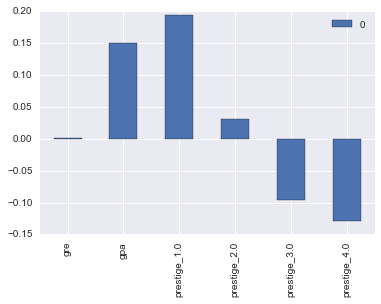

In [150]:
coefs = pd.DataFrame(fitted1.coef_, index=train.columns)
print coefs
coefs.plot(kind='bar')

This basic analysis strongly suggests that `prestige`, or more specifically, `prestige=1` (i.e., graduating from a top-ranked undergraduate program) is the strongest predictor of admission.
We can further verify the importance of `prestige` by comparing the performance of models that take it into account against models that do not.

In [151]:
def measure_model(cols, title, label):
    lm = linear_model.LogisticRegression()
    lm.fit(cols, admit)
    probs = lm.predict_proba(cols).T[1]
    vals = metrics.roc_curve(admit, probs)
    preds = np.around(probs)
    print 'F1 score: ' + str(metrics.f1_score(admit, preds))
    print 'ROC score: ' + str(metrics.roc_auc_score(admit, probs))
    plot = plt.subplot(111)
    plot.set(title=title, ylabel='', xlabel='', xlim=(0,1), ylim=(0,1))
    plot.plot(vals[0], vals[1], label=label)

F1 score: 0.321428571429
ROC score: 0.68089966614


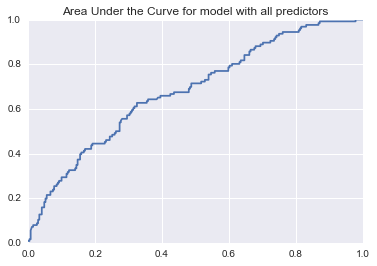

In [152]:
measure_model(train, 'Area Under the Curve for model with all predictors', 'all predictors')

F1 score: 0.0
ROC score: 0.615914016283


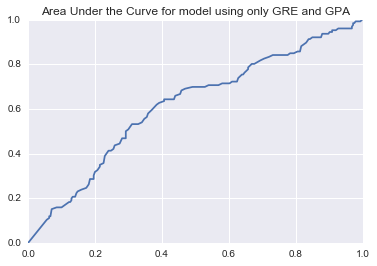

In [154]:
merit = admissions[['gpa', 'gpa']]
measure_model(merit, 'Area Under the Curve for model using only GRE and GPA', 'GRE and GPA')

*NB: the shape of the GRE and GPA data precluded the calculation of an F1 score for this model.*

F1 score: 0.352941176471
ROC score: 0.644716804311


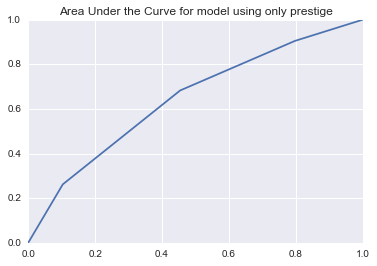

In [155]:
prest_only = admissions[[c for c in admissions.columns if c.startswith('prestige_')]]
measure_model(prest_only, 'Area Under the Curve for model using only prestige', 'prestige')

F1 score: 0.352941176471
ROC score: 0.579291864347


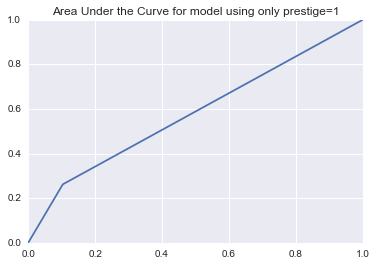

In [156]:
measure_model(admissions[['prestige_1.0']], 'Area Under the Curve for model using only prestige=1', 'prestige')

We can see that by ROC score, a model that takes into account _only_ whether a student graduated from a top-ranked program (e.g., not only disregarding GRE and GPA, but also treating students from 2nd- through 4th-ranked programs identically) is nearly 95% as accurate as a model that makes predictions based on GRE and GPA while ignoring `prestige`. We can additionally see that models that only account for `prestige` perform _better_ than the baseline (all predictors) model when measured by F-score.

### Further discussion and future analysis

The above analysis clearly demonstrates that, *according to this data set*, prestige of undergraduate program&mdash;specifically, whether an applicant has graduated from a top-ranked program&mdash;is the strongest predictor of whether that applicant will be admitted. There are, however, several directions that could be taken from this point:

* This data set is, according to its source, "hypothetical." While we do not intend to look a gift horse in the mouth, it would be interesting to see whether the conclusions drawn from this dataset hold up on actual admissions data, or even a greater volume of data generated in the same way.

* Similarly, these data are 'flattened': there is little we can do to subdivide them further. Similar data that also included information about date of application and program applied to, for example, would result in a richer and more applicable set of results.